## Model Estimation

$
y_t = \mu + \epsilon_t \\
\epsilon_t \sim \mathcal{N}(0, \sigma^2_{\epsilon} exp(h_t)) \\
h_{t+1} = \mu + \phi(h_{t} - \mu) + \xi_t \\
    \textrm{where } \xi_t \sim \mathcal{N}(0, \sigma^2_{\xi})
$

In [365]:
import numpy as np
import pandas as pd
import random as rd
import math
import scipy as sp
import matplotlib.pyplot as plt

##### i) Simulate the Model

In [366]:
from SV_Functions import sv_simul, sv_simul_v2
from scipy.optimize import minimize

### QML Estimation (Francq, Zakoian)

##### canonical SV Model

$
\epsilon_t = \sqrt{h_t} \eta_t \\
log(h_t) = \omega + \beta log(h_{t-1}) + \sigma v_t
$

$
\eta_t \sim \mathcal{N}(0,1) \\
v_t \sim \mathcal{N}(0,1)
$

##### State-space model

$
log (\epsilon_t^2) = log (h_t) + \mu_Z + u_t \\
log (h_t) = \beta log (h_{t-1}) + \omega + \sigma v_t
$

In [367]:
def sv_simul_can(θ, log_h0):
    ω = θ[0]
    α = θ[1]
    σ = θ[2]
    η = np.random.normal(0, 1, T)
    v  = np.random.normal(0, 1, T)
    ϵ_t = np.empty(0)
    log_h = np.empty(0)

    log_h = np.append(log_h, ω + β * log_h0 + σ * v[0])
    ϵ_t = np.append(ϵ_t, np.sqrt(np.exp(log_h[0])) * η[0])

    for t in range(1, T):
        log_h = np.append(log_h, ω + β * log_h[t-1] + σ * v[t])
        ϵ_t = np.append(ϵ_t, np.sqrt(np.exp(log_h[t])) * η[t])
        
    return ϵ_t, log_h

In [368]:
# Inputs
ω = 1e-3
β = 0.9
σ = 0.8
θ = ω, β, σ
log_h0 = ω
T = 500

In [369]:
data = sv_simul_can(θ, log_h0)
ϵ_t = data[0]
log_h = data[1]

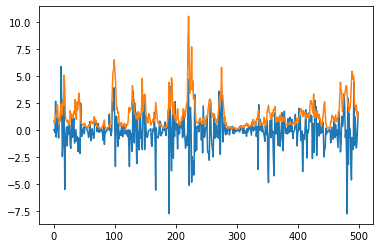

In [370]:
plt.plot(range(T), ϵ_t)
plt.plot(range(T), np.sqrt(np.exp(log_h)))

In [371]:
def obj_sv(θ, ϵ_t):
    α_t = np.empty(0)
    P_t = np.empty(0)
    F_t = np.empty(0)
    K_t = np.empty(0)
    ω = θ[0]
    β = θ[1]
    σ = θ[2]
    μ_Z = -1.270
    σ_Z = np.pi**2 / 2
    a0 = 0
    β0 = 0.8
    P0 = σ**2
    F0 = P0 + σ_Z**2
    T = len(ϵ_t)
    y_t = np.log(np.square(ϵ_t))
    
    α_t = np.append(α_t, β0 * a0 + ω)
    P_t = np.append(P_t, σ**2)
    K_t = np.append(K_t, β * P0 * 1/F0)
    
    for t in range(1,T):
        F_t = np.append(F_t, P_t[t-1] + σ_Z**2)
        K_t = np.append(K_t, β * P_t[t-1] * 1/F_t[t-1])
        α_t = np.append(α_t, β * α_t[t-1] + K_t[t] * (y_t[t-1] - α_t[t-1] - μ_Z) + ω)
        P_t = np.append(P_t, β**2 * P_t[t-1] - K_t[t]**2 * F_t[t-1] + σ**2)
    F_t = np.append(F_t, P_t[T-1] + σ_Z**2)
    
    qml = -T/2 * np.log(2*np.pi) - 1/2 * np.sum(np.log(F_t) + np.square((np.log(np.square(ϵ_t)) - α_t - μ_Z)) / F_t)
    return -qml

In [372]:
def estim_sv(θ0, ϵ_t):
    valinit = θ0
    res = minimize(obj_sv, valinit, args=(ϵ_t), bounds=((1e-5, math.inf), (0, 0.99), (0, math.inf))) 
    θ_hat = res.x
    likeli = res.fun
    return θ_hat, likeli

In [373]:
ω0 = 1e-3
β0 = 0.85
σ0 = 0.9
θ0 = ω0, β0, σ0

In [374]:
estimation = estim_sv(θ0, ϵ_t)
θ_hat = estimation[0]
θ_hat

array([1.e-05, 0.e+00, 0.e+00])

### SV Model Estimation - Monte Carlo

In [375]:
M = 2000

In [376]:
ω_spread = np.empty(0)
β_spread = np.empty(0)
σ_spread = np.empty(0)
for j in range(M):
    results = garch_simul(θ, T)
    ϵ_t = results[0]
    estimation = estim_garch(θ0, ϵ_t)
    θ_hat = estimation[0]
    ω_hat = θ_hat[0]
    β_hat = θ_hat[1]
    σ_hat = θ_hat[2]
    ω_spread = np.append(ω_spread, ω_hat - ω)
    β_spread = np.append(β_spread, β_hat - β)
    σ_spread = np.append(σ_spread, σ_hat - σ)

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

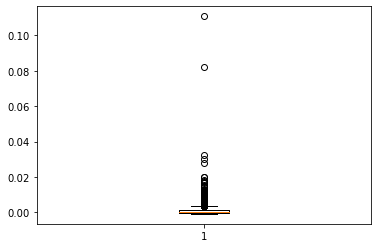

In [377]:
plt.boxplot(ω_spread)
np.seterr(divide = 'ignore') 

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

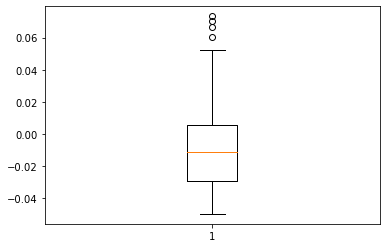

In [378]:
plt.boxplot(α_spread)
np.seterr(divide = 'ignore') 

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

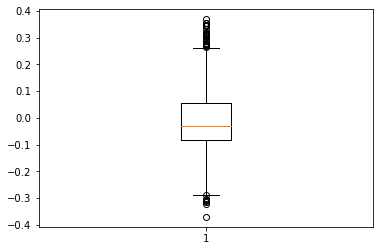

In [379]:
plt.boxplot(β_spread)
np.seterr(divide = 'ignore') 

### Estimate GARCH Models

In [74]:
def garch_simul(θ, T):
    η = np.random.normal(0, 1, T)
    ϵ_t = np.empty(0)
    σ2 = np.empty(0)
    ω = θ[0]
    α = θ[1]
    β = θ[2]
    
    ϵ_t = np.append(ϵ_t, np.sqrt(ω) * η[0])
    σ2 = np.append(σ2, ω)
    
    for t in range(1, T):
        σ2 = np.append(σ2, ω + α * ϵ_t[t-1]**2 + β * σ2[t-1])
        ϵ_t = np.append(ϵ_t, np.sqrt(σ2[t]) * η[t])
        
    return ϵ_t, σ2

In [75]:
def obj_garch(θ, ϵ_t):
    ω = θ[0]
    α = θ[1]
    β = θ[2]
    T = len(ϵ_t)
    σ2 = np.empty(0)
    
    σ2= np.append(σ2, ω)
    for t in range(1,T):
        σ2 = np.append(σ2, ω + α * ϵ_t[t-1]**2 + β * σ2[t-1])
    qml = np.mean(np.log(σ2[1:T]) + np.square(ϵ_t[1:T]) / σ2[1:T])
    return qml

In [76]:
def estim_garch(θ, ϵ_t):
    valinit = θ
    res = minimize(obj_garch, valinit, args=(ϵ_t), bounds=((1e-4, math.inf), (0, math.inf), (0, 0.999))) 
    θ_hat = res.x
    likeli = res.fun
    return θ_hat, likeli

In [77]:
ω = 1e-3
α = 0.05
β = 0.9
θ = ω, α, β

In [78]:
results = garch_simul(θ, T)
ϵ_t = results[0]
σ2 = results[1]

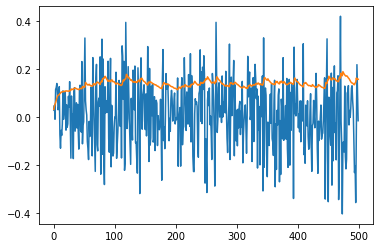

In [79]:
plt.plot(range(T), ϵ_t)
plt.plot(range(T), np.sqrt(σ2))

In [80]:
ω0 = 1e-3
α0 = 0.1
β0 = 0.8
θ0 = ω0, α0, β0

In [81]:
estimation = estim_garch(θ0, ϵ_t)
θ_hat = estimation[0]
θ_hat - θ

array([ 0.00146761,  0.03494167, -0.10814077])

### GARCH Monte Carlo Experiment

In [82]:
M = 100

In [83]:
ω_spread = np.empty(0)
α_spread = np.empty(0)
β_spread = np.empty(0)
for j in range(M):
    results = garch_simul(θ, T)
    ϵ_t = results[0]
    estimation = estim_garch(θ0, ϵ_t)
    θ_hat = estimation[0]
    ω_hat = θ_hat[0]
    α_hat = θ_hat[1]
    β_hat = θ_hat[2]
    ω_spread = np.append(ω_spread, ω_hat - ω)
    α_spread = np.append(α_spread, α_hat - α)
    β_spread = np.append(β_spread, β_hat - β)

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

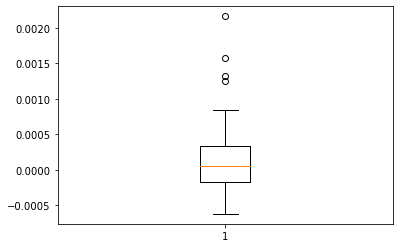

In [84]:
plt.boxplot(ω_spread)
np.seterr(divide = 'ignore') 

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

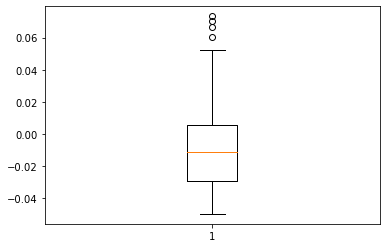

In [85]:
plt.boxplot(α_spread)
np.seterr(divide = 'ignore') 

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

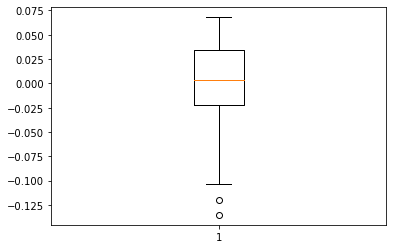

In [86]:
plt.boxplot(β_spread)
np.seterr(divide = 'ignore') 